# Fraud POC



This is a prototype/proof-of-concept of a ML solution for Fraud Detection for e-commerce,
completely built in Python and backed by Dask to parallelize data processing and model training
and hopeit.engine to "productionize" training pipeline and prediction service as microservices.

Author: Leo Smerling 

LinkedIn: https://www.linkedin.com/in/leosmerling/

[Dask](https://dask.org/) is a distributed processing engine for Python that can be used to process high data loads in distributed environments, such a Dask cluster. It has APIs built on top of popular Numpy and Pandas libraries.

[hopeit.engine](https://github.com/hopeit-git/hopeit.engine): is an (upcoming) open-source library that I am contributing to, that enables to quickly develop microservices in Python. hopeit.engine is built on top of aiohttp to provide API endpoints and async processing, and also provides distributed processing of streaming events using [Redis Streams](https://redis.io/topics/streams-intro). Streaming data, authorization, logging, metrics and tracking/tracing are added to your microservice out of the box.

To enable development, testing and working with the data in an unified environment I use [nbdev](https://github.com/fastai/nbdev). nbdev allows to explore data, create the services and test using Jupyter Notebooks. hopeit.engine and Dask plays well also with Juypyter notebooks, so the whole pipeline and prediction service can be developed and tested from Jupyter.

This repo shows and end-to-end example of a Fraud Detection system consisting of:
- Data preprocessing and partitioning (using Dasks Dataframes API)
- Feature calculation (using Dasks Dataframes API)
- Preparing data for model training (using Dasks Dataframes API)
- Training a model (distributed Dask XGBoost)
- Preparing data to serve predictions (using Dask + Redis)
- Prepare and run a microservice to orchestrate and monitor the data + training pipeline (using hopeit.engine)
- Prepare and run a microservice to predict fraud on new orders (using hopeit.engine) 

**DISCLAIMER**: The objective of this project is to quickly show an example on how Data + Feature Extraction +
Model Trainig + Prediction can be developed and prepared for production. The data used for this example
is randomly generated orders, and neither the features selected and model parameteres were optimized
given the nature of data used. The intention is to give an overview of the tools and the approach to quickstart a project that could evolve into a mature state by improving each one of its pieces.


### Getting started

(Feel free to report issues if you find the procedure below not working, I've tested only in a Linux environment)

* I recommend to install [Anaconda](https://docs.anaconda.com/anaconda/install/) (virtualenv can be used also -- not tested --)


* Create a conda environment, activate and install jupyterlab, nbdev and dask
```
conda create -n fraud-poc python=3.7
conda activate fraud-poc
conda install jupyterlab
conda install -c conda-forge dask graphviz python-graphviz 
pip install nbdev
nbdev_install_git_hooks
```


* Install hopeit.engine from provided library (preview version, do not use in production):
```
cd install
source install-hopeit-engine.sh
cd ..
```


* Finally install this project and dependencies in development mode
```
pip install -e .
```


* In order to run the microservices (optional) Redis is required. You can run redis for development, from the provided docker configuration:
```
cd docker
pip install docker-compose
docker-compose up -d redis
cd ..
```

* You can start a Dask cluster using docker or locally:

Docker:
```
docker-compose up dask-scheduler
docker-compose up dask-worker
```

Locally:
```
dask-scheduler
dask-worker tcp://localhost:8786 --memory-limit 2GB
```

* Create a folder to store data
```
mkdir data
```
(location can be changed from config files)


* To open, visualize and edit notebooks run from the root folder of the project
```
jupyter lab
```



### Overview:

* Notebooks prefixed from 00* to 09* are created for each component/event of the pipeline and prediction service. Check each notebook for a brief description of what they do:
    
* Cells marked with #export, will generate a python file inside fraud_poc/ folder that can be executed by hopeit.engine
        
* To generate/update the code, run `nbdev_build_lib` (no need to do it if you haven't change the code, modules are already generated in the repo)
        
* Usually the last cells of the notebooks, are a test case that can be run locally and invoke the generated file, gather data and do some checks/analysis. I saved the notebooks with the outputs so you can visualize some examples without needing to install anything.        
        
* Inside config/ folder there are configuration files to run two microservices:

    * `training_pipeline.json` and `openapi-training.json` describe the service to run data preparation and training pipeline using hopeit.engine
    
    * `fraud-service.json` and `openapi-service.json` configure a service to perform real-time predictions on new orders based on the training model and aggregated data
    

#### Training Pipeline

As a result of configuration in `config/training-config.json` plus implemented Python modules generated from Notebooks 00* to 07, the following training pipeline is implemented, where event (green) is notified by the previous step using streams (blueish):

In [ ]:
#hide
from hopeit.testing.apps import config
from fraud_poc.diagrams import draw_graph

training_config = config('config/training-pipeline.json')
pipeline_diagram = draw_graph(training_config, show_streams=True)

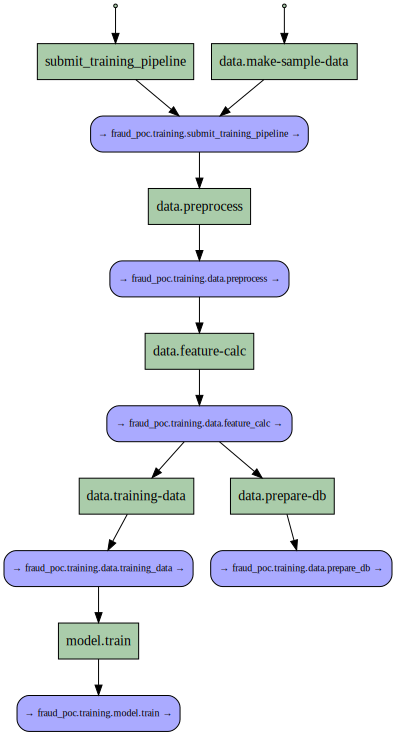

In [ ]:
pipeline_diagram

There are two entry points:

* make_sample_data: endpoint to create sample data and trigger the pipeline steps.
* submit_training_pipleine: endpoint to trigger pipeline steps from already existing data

#### Inference Service

As configured in `fraud-service.json` with events implementes in notebooks 08* to 09*, there is a resulting service with two endpoints:

In [ ]:
#hide
from hopeit.testing.apps import config
from fraud_poc.diagrams import draw_graph

service_config = config('config/fraud-service.json')
service_diagram = draw_graph(service_config)

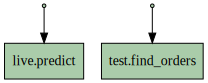

In [ ]:
service_diagram

* live.predict: endpoint required to enter order information and return predictions and calculated feature values.
* test.find_orders: it's a helper endpoint to find random generated orders to be used in this example

### Data processing and training pipeline

* To run training pipeline service:

```
hopeit_server run --config-files=config/server.json,config/training-pipeline.json --api-file=config/openapi-training.json --start-streams --port=8020
```
        
You should see a couple endpoints in http://localhost:8020/api/docs

* The first endpoint "Data: Make Sample Data" will run the whole data+training pipeline end to end if you click in `Try It`
![](docs/img/api01.png)

1) **create-sample-data**: will create random orders in parquet format into folder `./data/raw/`. This dataset is partitioned by time periods, i.e. 1 file per 30-day batch in this example. Once this step is finished the end of the job will be notified using hopeit.engine streams funcionallity and the next job will take place once the event is consumed.

2) **preprocess**: reads data generated in previous step and creates new parquet files partitioned by customer_id and email, so aggregations on those two dimensions can be performed more efficiently later. Again, once the job is finished, the next step will be notified. This generated files also can be use for data analysis and feature discovering using Jupyter and Dask.

3) **feature-calc**: calculates aggregations on customer_ids and emails (i.e. accumulates most recent emails, ip_addrs, counts, order_amounts, etc) and stores a new data set of orders enriched with this extra information.

4) **training-data**: prepares data for training: obtain labels for the orders (in this POC `is_fraud` label field is just assigned using a combination of calculations with some randomness) and creates a more balanced dataset subsampling non-fraud cases, creates a validation set using more recent non-fraud and fraud labeled transactions. Next step is notified when data is ready. The dataset is shuffle randomly into N partitions (10 in the example) so training can be performed from each partition using fairly-balanced datasets.

5) **train-model**: trains an XGBoost model on sampled data using Dask distributed implementation. Validates model precision and recall using validation dataset and if validation passes a configured treshold, model is saved to be used in prediction service.

6) **prepare-db**: stores most recent customer_id and email features calculated in step 3) into a Redis database that can be used for real-time prediction service. (Notice that this data should be continuously updated on new orders but this is not provided in this POC)

Since data generation could be tedious, there is a second endpoint that allows to run just from step 02, assuming
you already have raw data:
![](docs/img/api02.png)







### Fraud prediction service

To run the live prediction service:

```
hopeit_server run --config-files=config/server.json,config/fraud-service.json --api-file=config/openapi-service.json --start-streams --port=8021
```

You can try the endpoints using in http://localhost:8021/api/docs

* First extract some valid customer_id and email using:
```
curl -X GET "http://localhost:8021/api/fraud-poc/0x0x1-service/test/find-orders?prefix=*&num_items=10" \
 -H "Accept: application/json" 
```
This POC only can predict fraud for known customer_id and email in the generated data.

Using a customer_id and email, pass a new order to the service using the Live: Predict Endpoint:
![](docs/img/api03.png)

And check the results, all calcualted features plus an is_fraud field is returned:
```
{
  "order_id": "ce4798f5-6127-4d6e-bf1d-dda810eab26b",
  "order_date": "2020-07-07T06:33:18+00:00",
  "customer_id": "271d8c5e-e4e3-4377-a3e3-673ccf153664",
  "ip_addr": "f95e9c978b7f88dde5b9eb39417070251603db2d",
  "order_amount": 100.7097195892065,
  "email": "7545576ffe1b7c1d9d8d2e82d0191fa057df695f",
  "customer_id_by_email": [
    "271d8c5e-e4e3-4377-a3e3-673ccf153664"
  ],
  "num_customer_id_by_email": 1,
  "last_customer_id_by_email": "271d8c5e-e4e3-4377-a3e3-673ccf153664",
  "same_customer_id_by_email": 1,
  "known_customer_id_by_email": 1,
  "order_amount_mean_by_email": 468.79164250074143,
  "order_amount_std_by_email": 317.0635415216074,
  "order_amount_min_by_email": 68.2940660160266,
  "order_amount_max_by_email": 916.7097195892065,
  "order_amount_sum_by_email": 4687.916425007415,
  "order_amount_by_email": [
    769.0840886685221,
    68.2940660160266,
    164.22372869469348,
    198.35357128773578,
    454.66931470215576,
    100.7097195892065,
    779.1408217338134,
    916.7097195892065,
    854.4217419999278,
    382.3096527261267
  ],
  "key": "271d8c5e-e4e3-4377-a3e3-673ccf153664",
  "email_by_customer_id": [
    "7545576ffe1b7c1d9d8d2e82d0191fa057df695f"
  ],
  "ip_addr_by_customer_id": [
    "f95e9c978b7f88dde5b9eb39417070251603db2d",
    "788e574cf1934b34e9510ce897d8a593ab9dbcc9",
    "d02eae79264a401d76e853c41bdb781484443db2"
  ],
  "num_email_by_customer_id": 1,
  "num_ip_addr_by_customer_id": 3,
  "last_email_by_customer_id": "7545576ffe1b7c1d9d8d2e82d0191fa057df695f",
  "last_ip_addr_by_customer_id": "f95e9c978b7f88dde5b9eb39417070251603db2d",
  "same_email_by_customer_id": 1,
  "same_ip_addr_by_customer_id": 1,
  "known_email_by_customer_id": 1,
  "known_ip_addr_by_customer_id": 1,
  "order_amount_mean_by_customer_id": 468.79164250074143,
  "order_amount_std_by_customer_id": 317.0635415216074,
  "order_amount_min_by_customer_id": 68.2940660160266,
  "order_amount_max_by_customer_id": 916.7097195892065,
  "order_amount_sum_by_customer_id": 4687.916425007415,
  "order_amount_by_customer_id": [
    769.0840886685221,
    68.2940660160266,
    164.22372869469348,
    198.35357128773578,
    454.66931470215576,
    100.7097195892065,
    779.1408217338134,
    916.7097195892065,
    854.4217419999278,
    382.3096527261267
  ],
  "location_lat": 0,
  "location_long": 0,
  "is_fraud": 0.5424039363861084
}
```


So that's it, please feel free to submit feedback and suggestions! Please contact me in case you want to improve pieces like dataset generation, model tuning, etc.


I Hope you enjoyed it!